In [4]:
import pandas as pd
import numpy as np
import os
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import io
import json
import re
import ast 
import glob

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Error reporting workflow


1. Step 1: Gets these tables from data schema:

    * raw_df

    * validation_df

    * wetland_df

    * embed_df


In [6]:
# # Read the CSV file into a DataFrame
# main_df = pd.read_csv(r'data_schema/main_df_2023_11_20.csv')
# val_df = pd.read_csv(r'data_schema/validation_df_2023_11_20.csv')
# wetland_df = pd.read_csv(r'data_schema/wetland_final_df_2023_11_20.csv')

In [ ]:
# Step 1: Gets these tables from data schema

# Set the working directory
# os.chdir(r'D:\Work\Georgetown\acad\mdi\usace\git_repo\usace\EIDCDraft\pipeline')

directory = "data_schema/"

raw_df = pd.read_csv(f"{directory}raw_df.csv")
raw_df = raw_df.drop(columns = ["pdf_full_text", "pdf_trimmed"])

validation_df = pd.read_csv(glob.glob(f"{directory}validation_*")[0])

wetland_df = pd.read_csv(f"{directory}wetland_final_df_2023_11_20.csv")

    
### Step 2: errors in **RAW_DF**

    * Number of 'unknowns' by column/table

    * Scraping/URL errors

    * len(longitude list) == len(latitude list) for same noticeID
    
    * No. of special notices



In [110]:
# Step 2: raw_df

# Track PDF reading problems
pdf_reading = raw_df.pdf_text_flag.value_counts()
pdf_reading_table = pd.DataFrame({"PDF Reading Status": pdf_reading.index, "Count": pdf_reading.values})
pdf_reading_table["Percentage (%)"] = round((pdf_reading_table.Count / pdf_reading_table.Count.sum()) * 100, 2)
pdf_reading_table

# Count the number of valid texts, either from PDF or webpage
num_valid = raw_df[raw_df.pdf_text_flag != "Replaced with webpage text but no texts in the webpage body"].noticeID.count()
pct_valid = round(num_valid / raw_df.noticeID.count() * 100, 2)
print(f"{num_valid} ({pct_valid}%) of notices have valid texts")



# For those notices that have a valid texts, how many are special public notices?
special_flag = raw_df[raw_df.specialFlag != "ERROR: no pdf or webpage text found"].specialFlag.value_counts()
special_flag_table = pd.DataFrame({"Special Notice": ["No", "Yes"], "Count": special_flag.values})
special_flag_table["Percentage (%)"] = round((special_flag_table.Count / special_flag_table.Count.sum()) * 100)
special_flag_table

non_special_count = special_flag_table.loc[0, "Count"]
non_special_pct = special_flag_table.loc[0, "Percentage (%)"]
print(f"{non_special_count} ({non_special_pct}%) notices having texts from PDF or webpage are not special public notices.")



# How many of non-special notices have unknown values?
print("Non-special notices that have unknown values")

non_special = raw_df[raw_df.specialFlag == "0"]
unknown_counts = non_special.apply(lambda col: col[col == "unknown"].count())

# Calculate the percentage of 'unknown' values in each column
total_counts = non_special.apply(lambda col: col.count())
unknown_pct = round((unknown_counts / total_counts) * 100, 2)

unknown_table = pd.DataFrame({'Column': unknown_counts.index, 'Unknown Count': unknown_counts.values, 'Unknown Percentage (%)': unknown_pct.values})
unknown_table = unknown_table[unknown_table['Unknown Count'] != 0]
unknown_table = unknown_table.sort_values(by="Unknown Percentage (%)")
unknown_table



# How many of non-special notices have values reporting errors
print("Non-special notices that have errors")

error_counts = non_special.apply(lambda col: col[col.str.contains("ERROR", na=False)].count())
error_pct = (error_counts / total_counts) * 100

error_table = pd.DataFrame({'Column': error_counts.index, 'Error Count': error_counts.values, 'Error Percentage (%)': error_pct.values})
error_table = error_table[error_table['Error Count'] != 0]

# The main reason of error
column_error = error_table.Column.to_list()
error_table["Main Error"] = [non_special[non_special[col].str.contains("ERROR", na=False)][col].mode().iloc[0] for col in column_error]
error_table = error_table.sort_values(by="Error Percentage (%)", ascending=False)
error_table



# Check the lat/lon
print("Check the validation of lat/lon")
non_special_copy = non_special.copy()

# Convert string representations of lists to actual lists
non_special_copy["lat_check"] = ["[]" if x == "unknown" else x for x in non_special["pdf_latitude"]]
non_special_copy["lon_check"] = ["[]" if x == "unknown" else x for x in non_special["pdf_longitude"]]
non_special_copy['lat_check'] = non_special_copy['lat_check'].apply(ast.literal_eval)
non_special_copy['lon_check'] = non_special_copy['lon_check'].apply(ast.literal_eval)

# Compare the lengths of the lists
non_special_copy['length_comparison'] = non_special_copy.apply(lambda row: len(row['lat_check']) == len(row['lon_check']), axis=1)
non_special_copy.loc[~non_special_copy.length_comparison, ["noticeID", "usacePermitNumber", "PdfUrl", "pdf_location", "pdf_latitude", "pdf_longitude"]]

,PDF Reading Status,Count,Percentage (%)
0,normal,5551,84.76
1,Scanned PDFs; OCR applied,468,7.15
2,The PDF url is a dead link; replaced with webp...,360,5.50
3,No text in PDF (only attachment); replaced wit...,160,2.44
4,Replaced with webpage text but no texts in the...,10,0.15


6539 (99.85%) of notices have valid texts


,Special Notice,Count,Percentage (%)
0,No,5943,91.0
1,Yes,596,9.0


5943 (91.0%) notices having texts from PDF or webpage are not special public notices.
Non-special notices that have unknown values


,Column,Unknown Count,Unknown Percentage (%)
33,pdf_impact,64,1.08
28,pdf_character,64,1.08
19,applicantDetails,306,5.15
20,applicantCompanyName,306,5.17
12,pdf_comment_window,607,10.22
8,web_character,1134,19.09
24,pdf_latitude,1342,22.58
23,pdf_longitude,1358,22.85
6,web_applicant,1647,27.71
27,pdf_city,1686,28.37


Non-special notices that have errors


,Column,Error Count,Error Percentage (%),Main Error
7,web_location,1723,28.992092,ERROR: regex fails
9,web_mitigation,1643,27.645970,ERROR: regex fails; track back to web_avio_min...
33,pdf_impact,1207,20.309608,ERROR: cannot extract character of work ERROR:...
18,email,783,13.175164,ERROR: regex fails
16,name,487,8.639347,ERROR: regex fails
12,pdf_comment_window,453,7.623696,ERROR: regex fails
30,hydrologicUnitCode,414,7.309322,ERROR: cannot extract location of workERROR: r...
31,pdf_wqc,432,7.269056,ERROR: regex fails
22,pdf_location,414,6.967351,ERROR: regex fails
26,pdf_parish,414,6.966179,ERROR: cannot extract location of workERROR: r...


Check the validation of lat/lon


,noticeID,usacePermitNumber,PdfUrl,pdf_location,pdf_latitude,pdf_longitude
3,Notice_NO_1504,MVN-2017-01226-WQQ,http://www.mvn.usace.army.mil//Portals/56/docs...,"Located along Indian Bay of Prien Lake, in Cal...",['29.998158'],unknown
59,Notice_NO_1553,MVN-2021-00925-CFP,http://www.mvn.usace.army.mil//Portals/56/docs...,Located adjacent to Bayou Lafourche and LA Hwy...,unknown,['-90.228253']
77,Notice_NO_1566,MVN-2022-01059-WPP,http://www.mvn.usace.army.mil//Portals/56/docs...,"Located in the Gulf or Me xico, Outer Continen...",['27.9231339'],"['-91.567608', '-91.553897']"
79,Notice_NO_1568,MVN-2021-01280-EBB,http://www.mvn.usace.army.mil//Portals/56/docs...,"On the Tchefuncte River, at 115 Ann Street, Co...",['30.45303'],unknown
80,Notice_NO_1569,MVN-2005-00618-EBB,http://www.mvn.usace.army.mil//Portals/56/docs...,Located on the right descending bank of Bayou ...,['29.6799083'],unknown
...,...,...,...,...,...,...
6073,Notice_NO_6543,SAJ-2016-03221 (SP-SWA),http://www.saj.usace.army.mil//Portals/44/User...,ERROR: regex fails,['24.185'],unknown
6419,Notice_NO_6132,SAJ-1992-01740(MOD-LCK),http://cdm16021.contentdm.oclc.org/utils/getfi...,The project would affect waters of the United ...,['27.02863'],"['-80.11828', '-80.11343', '-80.08802', '-80.0..."
6430,Notice_NO_6429,SAJ-2010-03574 (SP-CGR),http://www.saj.usace.army.mil/,The project would affect waters of the United ...,['18.50277778'],"['-18.50277778', '-66.15861111', '-66.14138889..."
6508,Notice_NO_5704,ERROR: cannot pull from webpage title,https://usace.contentdm.oclc.org/utils/getfile...,The proposed project s would affect waters of ...,"['30.54445', '30.56000', '30.53417', '30.53000...","['-81.06750', '-81.04250', '-81.07000', '-81.0..."


In [ ]:
# Function to calculate unknown and NaN counts and percentages
def calculate_unknown_nan(df):
    results = []

    for column in df.columns:
        unknown_count = (df[column] == 'unknown').sum()
        nan_count = df[column].isna().sum()
        total_count = len(df)
        
        unknown_percent = (unknown_count / total_count) * 100
        nan_percent = (nan_count / total_count) * 100

        results.append({
            'Column': column,
            'Unknown Count': unknown_count,
            'Unknown Percent': unknown_percent,
            'NaN Count': nan_count,
            'NaN Percent': nan_percent
        })

    return pd.DataFrame(results)

# Generate the table
unknown_nan_table = calculate_unknown_nan(df)



### Step 3: errors in Wetland and Validation df

* API based errors (in LLMfunctions.py, get requests error (404, 202 etc.) and put in column)

* check rows where wetland_impact_unit = 0

* check rows where regex and OPenAI differ (NOTE - ONLY FOR FUTURE NOTICES)

* Value counts/table of different impact units+types



In [20]:
# Function to check if any dict in the list has 'impact_unit' equal to '0'
def check_impact_zero(json_str):
    try:
        data = json.loads(json_str)  # Load the string as JSON
        return any(d.get('impact_quantity') == '0' for d in data)  # Check if 'impact_unit' is '0' in any dict
    except json.JSONDecodeError:
        return False  # Return False if JSON is not valid

# Apply the function to each row in the 'wetland_llm_dict' column
val_df['impact_zero'] = val_df['wetland_llm_dict'].apply(check_impact_zero)


In [29]:
print("No. of wetland entries with impact_unit 0.0 = ", val_df['impact_zero'].sum() )

No. of wetland entries with impact_unit 0.0 =  0


In [86]:
x=val_df.wetland_llm_dict.sample(1).values[0]
x

nan

### PENDING - impact units

In [ ]:

def extract_units(json_str):
    # Convert single quotes to double quotes for valid JSON format
    json_str = json_str.replace("'", '"')

    # Parse the JSON string into a dictionary
    data = json.loads(json_str)

    # Extract the 'impact_unit' values from each object in the 'wetlands' list
    impact_units = [item.get('impact_unit') for item in data['wetlands']]

    return impact_units

val_df['impact_unit_list'] = val_df['wetland_llm_dict'].apply(extract_units)
val_df['impact_unit_list'].value_counts()

### OpenAI errors/difference w. regex

<Axes: >

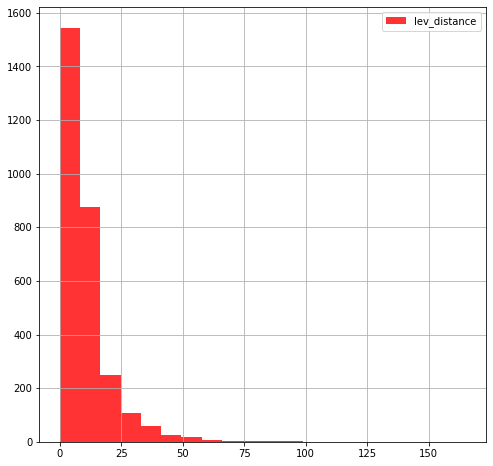

In [106]:
import Levenshtein

def extract_values_regex(text):
    # Pattern to match key-value pairs
    pattern = r"'(\w+)': '([^']*)'"
    matches = re.findall(pattern, text)

    # Create a dictionary from the matches
    result = []
    for key, value in matches:
        # Append the value to the corresponding key in the result dictionary
        result.append(value)
    return result


# Apply the function to each row
main_df['lev_distance'] = main_df.apply(lambda row: Levenshtein.distance(extract_values_regex(row['pdf_impact']), extract_values_regex(row['wetland_llm_dict'])), axis=1)


fig, ax = plt.subplots(1, figsize=(8, 8))

main_df[(main_df.len1<2000)].lev_distance.hist(color='red', alpha=.8, bins=20, legend=True)

In [ ]:
main_df['len1'] = main_df.pdf_impact.apply(lambda x: len(x))
main_df['len2'] = main_df.wetland_llm_dict.apply(lambda x: len(x))


In [ ]:
def determine_message(row):
    if row['len1'] == 2 and row['len2'] == 16:
        return 'Both returned NAs'
    elif row['len1'] == 2 and row['len2'] > 16:
        return 'Regex returned NAs'
    elif row['len2'] == 16  and row['len1'] != 2:
        return 'OpenAI returned NAs'
    elif row['len2'] != 16  and row['len1'] != 2 and row['lev_distance']>10:
        return 'Both returned different objects'
    else:
        return 'Both returned similar'

# Apply the function to each row
main_df['wetland_extraction'] = main_df.apply(determine_message, axis=1)
main_df.wetland_extraction.value_counts()

,web_title,pdf_impact,wetland_llm_dict,lev_distance,len1,len2
1770,SAJ-2020-01802 (SP-MRE),[],"{'wetlands': [{'wetland_type': 'unknown', 'imp...",5,2,147
1585,SAJ-2020-03996 (SP-AMC),[],"{'wetlands': [{'wetland_type': 'unknown', 'imp...",20,2,609
563,MVN-2005-03188-CO,[],"{'wetlands': [{'wetland_type': 'unknown', 'imp...",5,2,155
565,MVN-2007-2976-1-EPP,[],"{'wetlands': [{'wetland_type': 'unknown', 'imp...",5,2,155
1579,SAJ-2020-04101(SP-AMC),[],"{'wetlands': [{'wetland_type': 'unknown', 'imp...",5,2,155
570,MVN-2017-00153-CA,[],"{'wetlands': [{'wetland_type': 'unknown', 'imp...",5,2,155
571,MVN-2008-00959-CA,[],"{'wetlands': [{'wetland_type': 'unknown', 'imp...",5,2,155
1571,SAJ-2020-00984(SP-DSD),[],"{'wetlands': [{'wetland_type': 'unknown', 'imp...",5,2,155
573,MVN-1997-3061-WB,[],"{'wetlands': [{'wetland_type': 'unknown', 'imp...",5,2,171
575,MVN-2004-04834-CA,[],"{'wetlands': [{'wetland_type': 'unknown', 'imp...",5,2,155


<Axes: >

<Axes: >

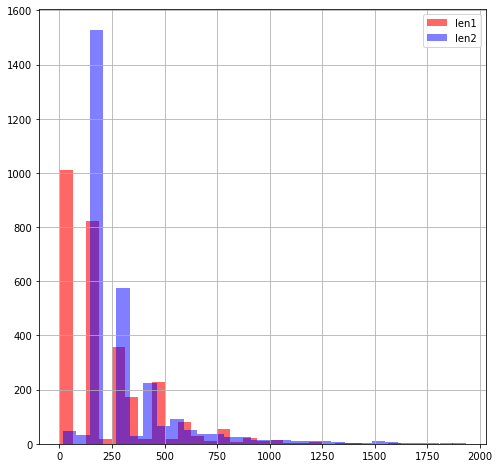

In [108]:
df = main_df[['web_title', 'pdf_impact', 'wetland_llm_dict', 'lev_distance', 'len1', 'len2']].copy()


df.sort_values(by='len1').head(10)

fig, ax = plt.subplots(1, figsize=(8, 8))

df[(df.len1<2000)].len1.hist(color='red', alpha=.6, bins=30, legend=True)

df[(df.len2<2000)].len2.hist(color='blue', alpha=.5, bins=30, legend=True)

In [110]:
df[[ 'pdf_impact', 'wetland_llm_dict', 'lev_distance']][(df.lev_distance>10) & (df.len1>15)].sample(1).values

array([["[{'impact_number': '780', 'impact_unit': 'linear feet', 'impact_number_type': 'project size', 'impact_condition': 'neutral', 'impact_duration': 'unknown'}, {'impact_number': '4400', 'impact_unit': 'linear feet', 'impact_number_type': 'project size', 'impact_condition': 'neutral', 'impact_duration': 'unknown'}, {'impact_number': '5.7', 'impact_unit': 'acre', 'impact_number_type': 'forested wetland', 'impact_condition': 'negative', 'impact_duration': 'unknown'}, {'impact_number': '0.7', 'impact_unit': 'acre', 'impact_number_type': 'jurisdictional waters', 'impact_condition': 'negative', 'impact_duration': 'unknown'}]",
        "{'wetlands': [{'wetland_type': 'forested wetlands', 'impact_quantity': '5.7', 'impact_unit': 'acres', 'impact_duration': 'unknown', 'impact_type': 'loss'}, {'wetland_type': 'jurisdictional waters', 'impact_quantity': '0.7', 'impact_unit': 'acre', 'impact_duration': 'unknown', 'impact_type': 'loss'}]}",
        17]], dtype=object)

###  Step 4: errors in embed_df

   * Total project area - check for zero


## Error type summary

- Columns affected
- Types of errors
- share of errors

## Report creation

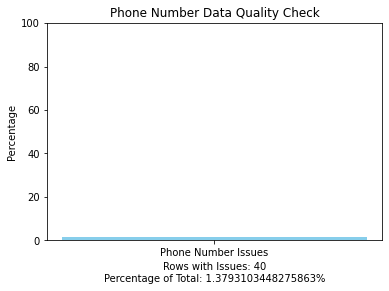

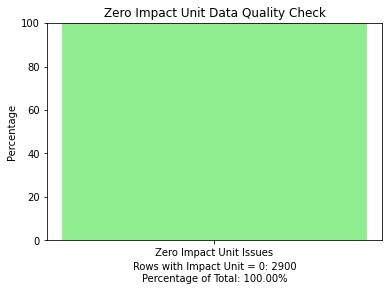

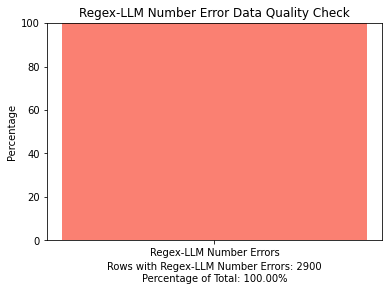

In [37]:

# Creating a PDF report
pdf_buffer = io.BytesIO()
with PdfPages(pdf_buffer) as pdf:
    # Page 1: Summary of phone number check
    fig, ax = plt.subplots()
    ax.bar('Phone Number Issues', phone_issue_percent, color='skyblue')
    ax.set_ylabel('Percentage')
    ax.set_title('Phone Number Data Quality Check')
    ax.set_ylim(0, 100)
    text_str = f'Rows with Issues: {phone_issue_count}\nPercentage of Total: {phone_issue_percent}%'
    ax.text(0.5, -0.1, text_str, ha='center', va='top', transform=ax.transAxes)
    pdf.savefig(fig)

    # Page 2: Summary of zero impact unit check
    fig, ax = plt.subplots()
    ax.bar('Zero Impact Unit Issues', zero_impact_percent, color='lightgreen')
    ax.set_ylabel('Percentage')
    ax.set_title('Zero Impact Unit Data Quality Check')
    ax.set_ylim(0, 100)
    text_str = f'Rows with Impact Unit = 0: {zero_impact_count}\nPercentage of Total: {zero_impact_percent:.2f}%'
    ax.text(0.5, -0.1, text_str, ha='center', va='top', transform=ax.transAxes)
    pdf.savefig(fig)

    # Page 3: Summary of Regex-LLM number error
    fig, ax = plt.subplots()
    ax.bar('Regex-LLM Number Errors', regex_llm_number_error_percent, color='salmon')
    ax.set_ylabel('Percentage')
    ax.set_title('Regex-LLM Number Error Data Quality Check')
    ax.set_ylim(0, 100)
    text_str = f'Rows with Regex-LLM Number Errors: {regex_llm_number_error_count}\nPercentage of Total: {regex_llm_number_error_percent:.2f}%'
    ax.text(0.5, -0.1, text_str, ha='center', va='top', transform=ax.transAxes)
    pdf.savefig(fig)


In [ ]:

# Save the PDF report to a file
pdf_file_path = '/mnt/data/data_quality_report.pdf'
with open(pdf_file_path, 'wb') as f:
    f.write(pdf_buffer.getvalue())

combined_report_path = '/mnt/data/combined_data_quality_report.pdf'
